In [1]:
from vqc_decoder_model_and_circuit import *

from jax.lib import xla_bridge
jax.experimental.enable_x64()
print("JAX Backend:", xla_bridge.get_backend().platform)

JAX Backend: gpu


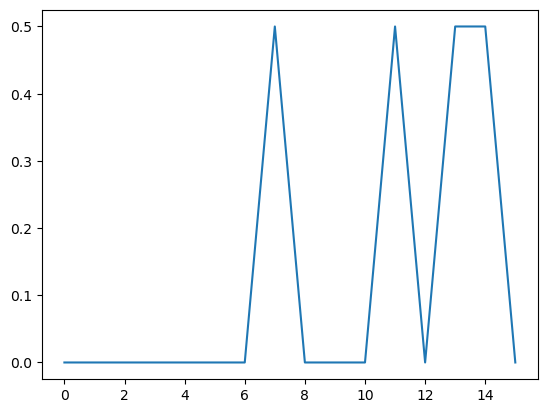

In [2]:
plt.plot(cat_data)

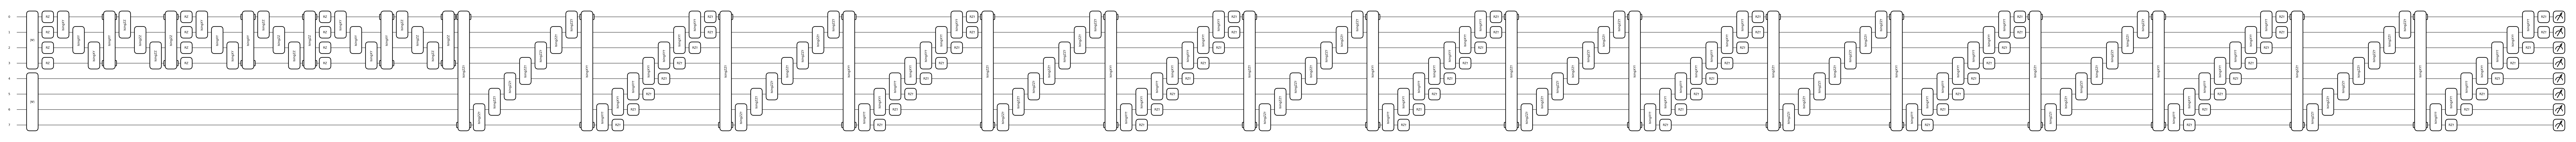

In [3]:
qml.draw_mpl(circuit,device='default')(input_params=initial_params)
plt.show()

In [4]:
# import numpy as np
# import matplotlib.pyplot as plt
# from itertools import combinations


# # Number of qubits
# num_qubits = 8

# # Generate all binary states with exactly 4 ones
# valid_states = ["".join("1" if i in comb else "0" for i in range(num_qubits)) 
#                 for comb in combinations(range(num_qubits), 4)]

# # Convert binary states to decimal indices
# valid_indices = [int(state, 2) for state in valid_states]

# # Create target distribution
# target_distribution = np.zeros(2**num_qubits)
# for index in valid_indices:
#     target_distribution[index] = 1  # Assign probability 1 to valid states

# # Normalize the distribution
# target_distribution /= np.sum(target_distribution)

# # Plot the target distribution
# plt.figure(figsize=(10, 5))
# plt.plot(target_distribution, linestyle="-", label="Superposition of 4 Ones & 4 Zeros")
# plt.xlabel("State Index")
# plt.ylabel("Probability")
# plt.title("Target Distribution for 4-Ones-4-Zeros Superposition")
# plt.legend()
# plt.show()


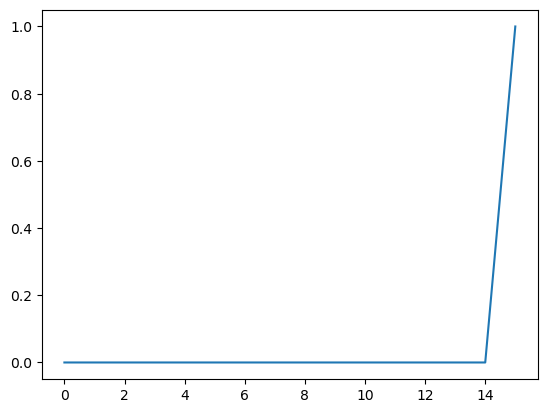

In [4]:
# import numpy as np

# Target binary pattern
target_binary = "11110000"

target_binary1 = '1111'
target_binary2 = '0000'
# Convert binary to decimal index
target_index1 = int(target_binary1, 2)
target_index2 = int(target_binary2, 2)

# Create a one-hot encoded target distribution
num_qubits = 4
target_distribution1 = np.zeros(2**num_qubits)
target_distribution1[target_index1] = 1

target_distribution2 = np.zeros(2**num_qubits)
target_distribution2[target_index2] = 1

# plt.subplot(1, 2, 1)
plt.plot(target_distribution1)
# plt.plot(target_distribution2)

In [5]:
class MMD:
    def __init__(self,scales,space):
        gammas = 1/(2*(scales**2)).reshape(-1,1,1)
        sq_dists = jnp.abs(space[:,None] - space[None,:])**2
        self.K = jnp.sum(jnp.exp(-gammas * sq_dists), axis=0)/len(scales)
        self.scales = scales
        
    def k_expval(self,px,py):
        return px @ self.K @ py
    
    def __call__(self,px,py):
        pxy = px-py
        return self.k_expval(pxy,pxy)
    
class QCBM:
    def __init__(self,circ,mmd1,mmd2,py1,py2):
        self.circ = circ
        self.mmd1 = mmd1
        self.mmd2 = mmd2
        self.py1 = py1
        self.py2 = py2
    
    def mmd_loss(self,params):
        px = self.circ(params)
        loss1 = self.mmd1(px[0],self.py1)
        loss2 = self.mmd2(px[1],self.py2)
        
        return loss1+loss2, px
    

#Model Training
@jit
def update_step(params,opt_state):
    
    (total_loss_val,qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss,has_aux=True)(params)

    updates,opt_state = opt.update(grads,opt_state)
    params = optax.apply_updates(params,updates)
    
    qcbm_probs1 = jnp.asarray(qcbm_probs[0], dtype=jnp.float64)
    qcbm_probs2 = jnp.asarray(qcbm_probs[1], dtype=jnp.float64)
    
    kl_div1 = -jnp.sum(target_distribution1 * jnp.nan_to_num(jnp.log(qcbm_probs1) - jnp.log(target_distribution1)))
    kl_div2 = -jnp.sum(target_distribution2 * jnp.nan_to_num(jnp.log(qcbm_probs2) - jnp.log(target_distribution2)))
    
    total_kl_div = kl_div1 + kl_div2
    
    return params, opt_state, total_loss_val, total_kl_div

### Cells to be run if the target_distribution corresponds to superposition of all half filled states

In [7]:
# #Calling MMD class
# bandwidth = jnp.array([0.25,60],dtype=jnp.float64)
# space = jnp.arange(0,2**total_qubits,dtype=jnp.float64)
# mmd = MMD(bandwidth,space=space)


# #Calling QCBM class to run the previous built circuit with random weights
# qcbm = QCBM(circuit,mmd=mmd,py=target_distribution)


# #Initial parameters
# weights = initial_params
# lr = optax.exponential_decay(init_value=0.1,transition_steps=10,decay_rate=0.99,transition_begin=300,end_value=0.025,staircase=True)
# # lr = 0.01
# opt = optax.adam(learning_rate=lr)
# opt_state = opt.init(weights)


# history = []
# divs = []
# parameters = []


# kl_div = 1
# i = 0
# # i = start_epoch

# # while kl_div > 10^-3:
# while i < 10001:
#     i+=1
#     current_lr = lr(i)
#     # current_lr = lr
#     start_time = time.time()
#     weights, opt_state, loss_val, kl_div = update_step(params=weights,opt_state=opt_state)
#     end_time = time.time()
    
#     if i%10==0:
#         print(f"Step: {i} Loss: {loss_val} KL_div:{kl_div} current_lr:{current_lr} Time taken per iteration: {end_time-start_time}")
    
#     history.append(loss_val)
#     divs.append(kl_div)
#     parameters.append(weights)
    

In [8]:
# fig, axs = plt.subplots(1,2,figsize=(15,8))
# axs[0].plot(divs)
# axs[0].title.set_text('KL Divergence')

# axs[1].plot(history)
# axs[1].title.set_text('loss')

In [9]:
# optimal_params = parameters[np.argmin(divs)]

# qcbm_probs = circuit(optimal_params)
# x_array = jnp.arange(0,2**(total_qubits),dtype=jnp.float64)


# plt.bar(x_array,qcbm_probs,color='green',alpha=0.5,label='Obtained Cat')
# # plt.plot(x_array,target_distribution,color='blue',alpha=0.5,label='Original Cat')
# # axs[0].title.set_text('Target Distribution')

### Cells to be run if target_distribution is only 10101010

In [8]:
#Calling MMD class
bandwidth = jnp.array([0.25,60],dtype=jnp.float64)
space = jnp.arange(0,2**n_qubits,dtype=jnp.float64)
mmd1 = MMD(bandwidth,space=space)
mmd2 = MMD(bandwidth,space=space)


#Calling QCBM class to run the previous built circuit with random weights
qcbm = QCBM(circuit,mmd1=mmd1,mmd2=mmd2,py1=target_distribution1,py2=target_distribution2)


#Initial parameters
weights = initial_params
lr = optax.exponential_decay(init_value=0.1,transition_steps=10,decay_rate=0.99,transition_begin=300,end_value=0.025,staircase=True)
# lr = 0.01
opt = optax.adam(learning_rate=lr)
opt_state = opt.init(weights)


history = []
divs = []
parameters = []


kl_div = 1
i = 0
# i = start_epoch

# while kl_div > 10^-3:
while i < 3001:
    i+=1
    current_lr = lr(i)
    # current_lr = lr
    start_time = time.time()
    weights, opt_state, loss_val, kl_div = update_step(params=weights,opt_state=opt_state)
    end_time = time.time()
    
    if i%10==0:
        print(f"Step: {i} Loss: {loss_val} KL_div:{kl_div} current_lr:{current_lr} Time taken per iteration: {end_time-start_time}")
    
    history.append(loss_val)
    divs.append(kl_div)
    parameters.append(weights)
    

Step: 10 Loss: 0.15501442551612854 KL_div:0.9122564792633057 current_lr:0.10000000149011612 Time taken per iteration: 0.042124271392822266
Step: 20 Loss: 0.0923796147108078 KL_div:0.6587365865707397 current_lr:0.10000000149011612 Time taken per iteration: 0.004742145538330078
Step: 30 Loss: 0.05899803340435028 KL_div:0.5015463829040527 current_lr:0.10000000149011612 Time taken per iteration: 0.004914283752441406
Step: 40 Loss: 0.025500576943159103 KL_div:0.3134116530418396 current_lr:0.10000000149011612 Time taken per iteration: 0.008130311965942383
Step: 50 Loss: 0.04656359553337097 KL_div:0.4260307550430298 current_lr:0.10000000149011612 Time taken per iteration: 0.004683017730712891
Step: 60 Loss: 0.06968408823013306 KL_div:0.535485029220581 current_lr:0.10000000149011612 Time taken per iteration: 0.004926204681396484
Step: 70 Loss: 0.026028919965028763 KL_div:0.31899845600128174 current_lr:0.10000000149011612 Time taken per iteration: 0.007863283157348633
Step: 80 Loss: 0.020452886

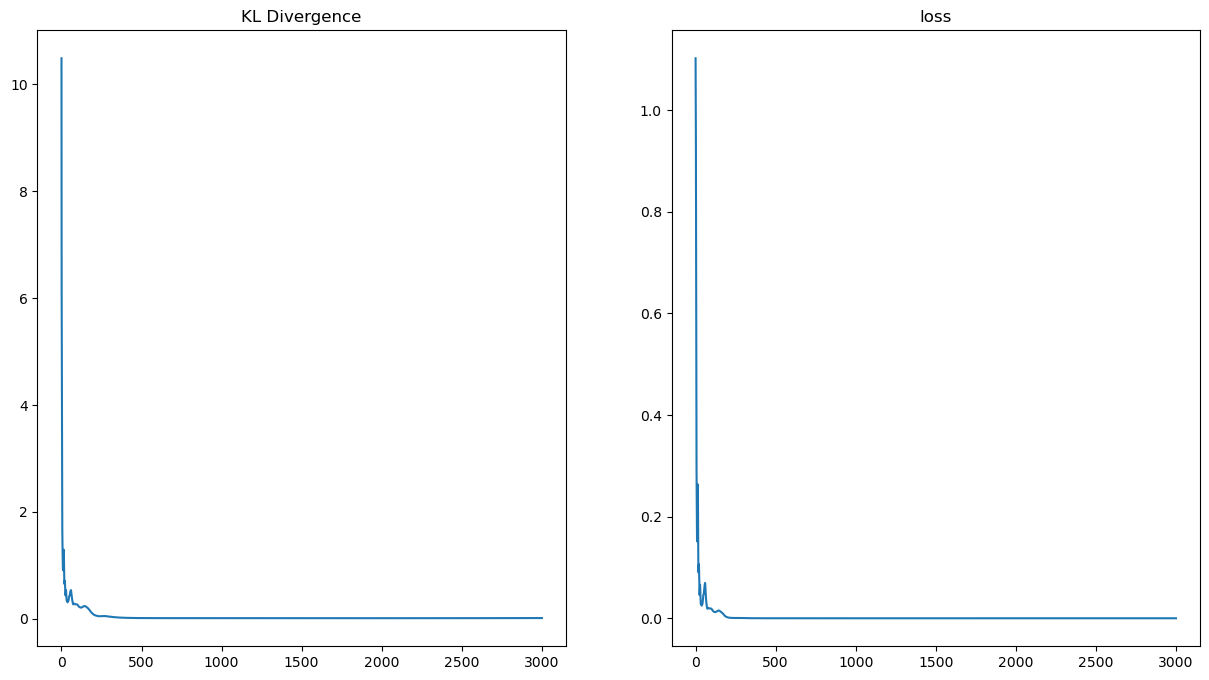

In [9]:
fig, axs = plt.subplots(1,2,figsize=(15,8))
axs[0].plot(divs)
axs[0].title.set_text('KL Divergence')

axs[1].plot(history)
axs[1].title.set_text('loss')

Text(0, 0.5, 'Probability Distribution')

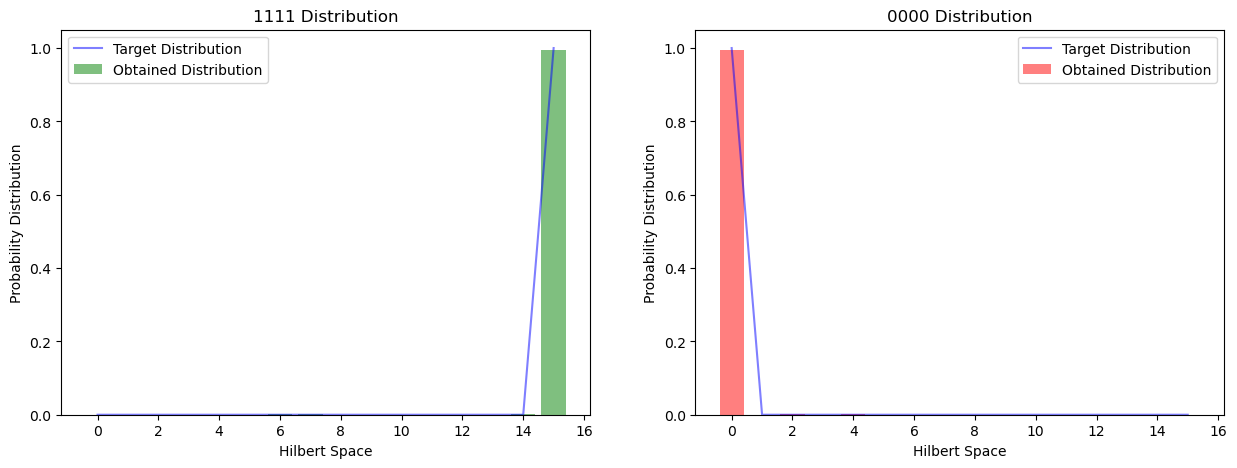

In [25]:
optimal_params = parameters[np.argmin(divs)]
qcbm_probs = circuit(optimal_params)
x_full = jnp.arange(0,2**n_qubits,dtype=jnp.float64)

fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].bar(x_full,qcbm_probs[0],color='green',alpha=0.5,label='Obtained Distribution')
axs[0].plot(x_full,target_distribution1,color='blue',alpha=0.5,label='Target Distribution')
axs[0].legend()
axs[0].set_title('1111 Distribution')
axs[0].set_xlabel('Hilbert Space')
axs[0].set_ylabel('Probability Distribution')

axs[1].bar(x_full,qcbm_probs[1],color='red',alpha=0.5,label='Obtained Distribution')
axs[1].plot(x_full,target_distribution2,color='blue',alpha=0.5,label='Target Distribution')
axs[1].legend()
axs[1].set_title('0000 Distribution')
axs[1].set_xlabel('Hilbert Space')
axs[1].set_ylabel('Probability Distribution')

In [11]:
print(f"Minimum KL Divergence obtained is {np.min(divs)}")

Minimum KL Divergence obtained is 0.008608363568782806


In [12]:
optimal_params

(Array([[ 0.2786298 ,  0.61443   , -0.36180893,  0.8162291 ,  0.2762766 ,
          1.0264714 ,  1.1157967 ,  0.15254045,  0.9517063 ,  0.02931046,
          0.09871054,  0.55314326],
        [-0.30240414,  1.0103819 ,  0.72247535,  0.89708304,  0.85229146,
          0.2664197 ,  1.0160754 ,  0.64102626,  0.26298678,  0.192016  ,
          0.7758906 ,  0.85607576],
        [ 0.9295802 ,  0.78181964,  1.2299023 ,  0.4261777 ,  0.6508104 ,
         -0.18352687,  0.54013103,  0.12037003,  0.27802575,  0.9841027 ,
          0.7886889 ,  0.421736  ]], dtype=float32),
 Array([[ 7.29382038e-03,  2.08911896e-02,  5.81426501e-01,
          3.61837983e-01,  2.23037720e-01,  1.19288325e-01,
          1.25438929e-01,  6.16829991e-01,  9.50073004e-02,
          9.83422518e-01,  4.24822092e-01,  8.32480073e-01,
          1.16073966e+00,  6.39151990e-01, -4.95099306e-01,
          1.83821708e-01,  1.26633954e+00,  2.15973616e+00,
         -6.11302078e-01, -9.63372111e-01,  9.57284644e-02,
          1

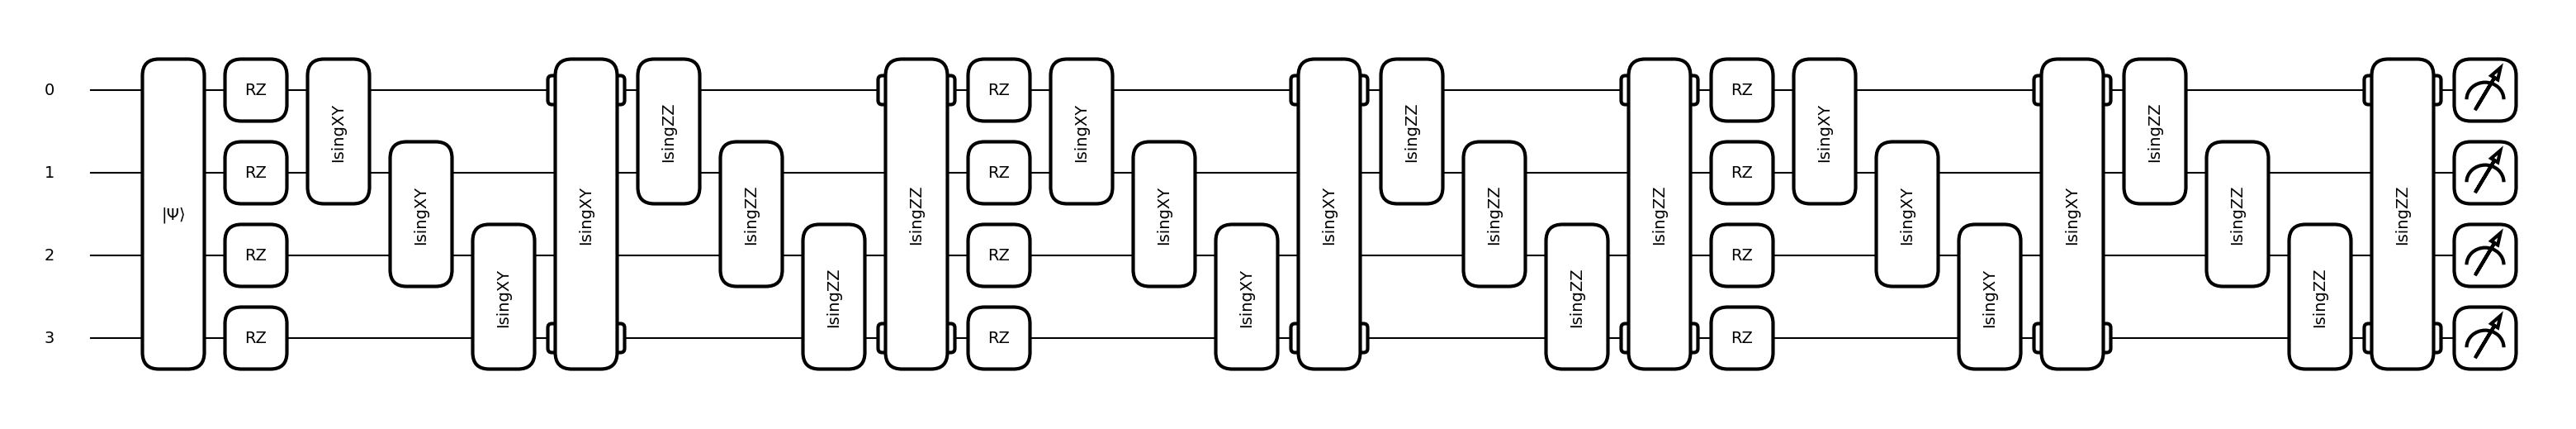

In [26]:
dev = qml.device("default.qubit",wires=n_qubits)

@qml.qnode(dev,interface='jax')
def output_vqc_circuit(input_params,n_qubits=4):
    uniform_init(num_qubits,cat_pre_training)
    params = input_params[0]
    for i in range(3):
        vqc_circuit(params[i])
    return qml.probs(wires=range(n_qubits))

qml.draw_mpl(output_vqc_circuit)(optimal_params)
plt.show()

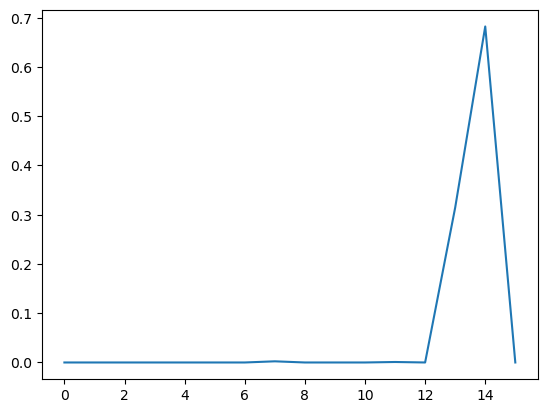

In [27]:
hybrid_output = output_vqc_circuit(optimal_params,n_qubits)
plt.plot(hybrid_output)

In [ ]:
# #Save Checkpoint
# checkpoint = {"final_epoch":i,
#               "history":history,
#               "divs":divs,
#               "parameters":parameters}

# with open(f'model_cat_anticat_distribution.pkl','wb') as file:
#     pickle.dump(checkpoint,file)
    
# print("Model saved successfully")